# **Irene Dovichi** 
## Midterm 3 - Assignment 3
Train a neural network for sequences of your choice (LSTM, GRU, Convolutional, Clockwork RNN, ...) to predict the Benzene (C6H6 column) based on the sensor measurements timeseries (PT08.* columns) being fed in input to the recurrent model. Evaluate the predictive accuracy of the network on the task (using appropriately training/validation splits).  Confront the perfomance of this model, with another recurrent neural network trained to predict benzene one-step-ahead, i.e. given the current benzene measuement, predict its next value.
Show and compare performance of both settings.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

## Dataset Loading

In [2]:
df = pd.read_csv('air+quality/AirQualityUCI.csv', sep=';', decimal=',', na_values=-200)

In [3]:
# Keep only Date, Time, C6H6, and PT08.* columns
df = df[['Date', 'Time', 'C6H6(GT)', 'PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']]
df.head()

,Date,Time,C6H6(GT),PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3)
0,10/03/2004,18.00.00,11.9,1360.0,1046.0,1056.0,1692.0,1268.0
1,10/03/2004,19.00.00,9.4,1292.0,955.0,1174.0,1559.0,972.0
2,10/03/2004,20.00.00,9.0,1402.0,939.0,1140.0,1555.0,1074.0
3,10/03/2004,21.00.00,9.2,1376.0,948.0,1092.0,1584.0,1203.0
4,10/03/2004,22.00.00,6.5,1272.0,836.0,1205.0,1490.0,1110.0


In [4]:
df.isna().sum()

Date             114
Time             114
C6H6(GT)         480
PT08.S1(CO)      480
PT08.S2(NMHC)    480
PT08.S3(NOx)     480
PT08.S4(NO2)     480
PT08.S5(O3)      480
dtype: int64

In [5]:
# Drop rows with nan values and reset index
df = df.dropna()
df = df.reset_index(drop=True)
df.isna().sum()

Date             0
Time             0
C6H6(GT)         0
PT08.S1(CO)      0
PT08.S2(NMHC)    0
PT08.S3(NOx)     0
PT08.S4(NO2)     0
PT08.S5(O3)      0
dtype: int64

In [6]:
df.shape

(8991, 8)

In [7]:
# Combine Date and Time columns into a single DateTime column
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S')
df = df.drop(columns=['Date', 'Time'])
df.insert(0, 'DateTime', df.pop('DateTime'))

In [8]:
# We notice that df is ordered by DateTime since the min is the first row and the max is the last row
print(df['DateTime'].min(), df['DateTime'].max())

# DateTime of first and last instances of the dataset
print(df['DateTime'].iloc[0], df['DateTime'].iloc[-1])

2004-03-10 18:00:00 2005-04-04 14:00:00
2004-03-10 18:00:00 2005-04-04 14:00:00


### Train/Test Split
Since the entire dataset covers more or less a year, we will inevitably have some months in the test set that were not present in the train. Therefore, I decided to do a basic 80/20 split for the train/test and then for the train/val. The only precaution I took was not to mix the instances to maintain temporal sequentiality, and I made sure the sets didn't break a certain day.

In [9]:
# Calculate 80% of length of df
train_size = int(len(df) * 0.8)
train_size

7192

In [10]:
df.iloc[7189:7194]

,DateTime,C6H6(GT),PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3)
7189,2005-01-15 23:00:00,11.1,1231.0,1017.0,655.0,1207.0,1414.0
7190,2005-01-16 00:00:00,13.6,1289.0,1104.0,623.0,1257.0,1499.0
7191,2005-01-16 01:00:00,9.8,1166.0,970.0,705.0,1136.0,1306.0
7192,2005-01-16 02:00:00,7.6,1062.0,884.0,748.0,1062.0,1172.0
7193,2005-01-16 03:00:00,6.0,1028.0,813.0,794.0,1019.0,1076.0


We can see that, by choosing instance 7189 as the last one for the train, we will get about 80% of the data as train data, and we avoid stopping in the middle of the measurements for a specific day.

In [11]:
train_start_date = df['DateTime'].iloc[0]
train_end_date = df['DateTime'].iloc[7189]

test_start_date = df['DateTime'].iloc[7190]
test_end_date = df['DateTime'].iloc[-1]

train = df[(df['DateTime'] >= train_start_date) & (df['DateTime'] <= train_end_date)]
test = df[(df['DateTime'] >= test_start_date) & (df['DateTime'] <= test_end_date)]

In [12]:
# Calculate 80% of length of train
train_size = int(len(train) * 0.8)
train_size

5752

In [13]:
train.iloc[5759:5764]

,DateTime,C6H6(GT),PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3)
5759,2004-11-11 21:00:00,16.8,1207.0,1203.0,625.0,1570.0,1251.0
5760,2004-11-11 22:00:00,4.8,904.0,754.0,930.0,1172.0,805.0
5761,2004-11-11 23:00:00,4.0,900.0,711.0,975.0,1153.0,736.0
5762,2004-11-12 00:00:00,4.5,932.0,740.0,926.0,1180.0,774.0
5763,2004-11-12 01:00:00,5.4,968.0,785.0,872.0,1209.0,826.0


In [14]:
train_start_date = train['DateTime'].iloc[0]
train_end_date = train['DateTime'].iloc[5761]

val_start_date = train['DateTime'].iloc[5762]
val_end_date = train['DateTime'].iloc[-1]

train = df[(df['DateTime'] >= train_start_date) & (df['DateTime'] <= train_end_date)]
val = df[(df['DateTime'] >= val_start_date) & (df['DateTime'] <= val_end_date)]

In [15]:
# Just a check that we have a reasonable number of instances
print(f'Wanted instances for train set: {int(len(df) * 0.8 * 0.8)} --> Actual instances: {len(train)}\n'
      f'Wanted instances for val set: {int(len(df) * 0.8 * 0.2)} --> Actual instances: {len(val)}\n'
      f'Wanted instances for test set: {int(len(df) * 0.2)} --> Actual instances: {len(test)}')

Wanted instances for train set: 5754 --> Actual instances: 5762
Wanted instances for val set: 1438 --> Actual instances: 1428
Wanted instances for test set: 1798 --> Actual instances: 1801


## Sensors Based Model
For the first task we select the columns of sensor measurements as input features, and Benzene as target.

In [16]:
X_train = train[['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']]
y_train = train['C6H6(GT)']

X_val = val[['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']]
y_val = val['C6H6(GT)']

X_test = test[['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']]
y_test = test['C6H6(GT)']

### Scaling
As for scaling, I decided to use `MinMaxScaler()` to keep the features in a range of [0,1] but maintaining their distributions.

In [17]:
# Scale X values
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Scale y values
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = y_scaler.transform(y_val.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

### Reshaping
I am going to use a LSTM layer, which requires the data to be in the form: `[samples, timesteps, features]`. I am going to add a new dimension to the data: `timesteps = 1`, since each input sample is a single timestep of 5 features (the PT08.* columns).

In [18]:
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_scaled = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

### Vanilla LSTM Model
Let's try a simple model: 1 LSTM layer with 10 units. The summary tells us that the LSTM layer has 640 parameters; in fact, it takes as input vectors of size *_m_*=5 and returns as output vectors of size *_n_*=10, and the number of parameters is $4(nm + n^2 + n)$.

In [21]:
model = Sequential()
model.add(Input(shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))  
model.add(LSTM(10, activation='relu', return_sequences=False, name='lstm'))  
model.add(Dense(1, name='dense'))  

model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')  

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 651 (2.54 KB)

 Trainable params: 651 (2.54 KB)

 Non-trainable params: 0 (0.00 B)

#### Training Phase

In [22]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=5, restore_best_weights=True)
history = model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=32, validation_data=(X_val_scaled, y_val_scaled), shuffle=False, callbacks=[early_stopping])

Epoch 1/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 887us/step - loss: 0.0402 - val_loss: 0.0159
Epoch 2/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 0.0104 - val_loss: 0.0068
Epoch 3/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 0.0039 - val_loss: 0.0030
Epoch 4/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 0.0017 - val_loss: 0.0030
Epoch 5/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 0.0016 - val_loss: 0.0029
Epoch 6/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 0.0015 - val_loss: 0.0027
Epoch 7/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 0.0014 - val_loss: 0.0025
Epoch 8/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 0.0013 - val_loss: 0.0024
Epoch 9/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 0.0013 - val_loss: 0.0023
Epoch 10/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 0.0012 - val_loss: 0.0022
Epoch 11/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 0.0012 - val_loss: 0.0020
Epoch 12/100
181/18

Test Loss: 3.020231451955624e-05



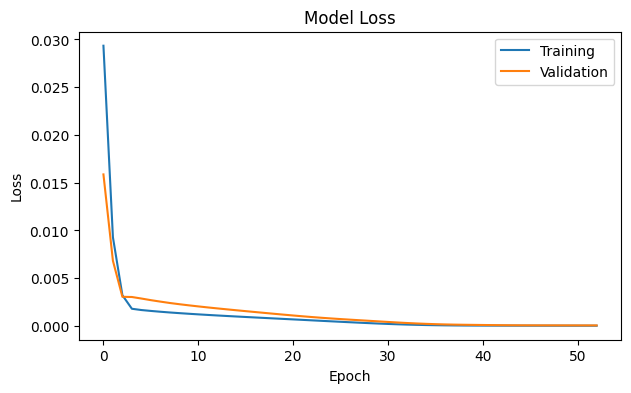

In [23]:
# Print test loss and accuracy
loss = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)
print(f'Test Loss: {loss}\n')

history = history.history

# Plot training & validation loss 
plt.figure(figsize=(7, 4))
plt.plot(history['loss'], label='Training')
plt.plot(history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

#### Predictions

In [24]:
y_pred_scaled = model.predict(X_test_scaled)
y_pred_scaled = y_pred_scaled.reshape(-1, 1)

y_pred = y_scaler.inverse_transform(y_pred_scaled)

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [25]:
y_test.shape, y_pred.shape

((1801,), (1801, 1))

In [26]:
y_test = y_test.values.reshape(-1, 1)
y_test.shape

(1801, 1)

In [27]:
mse = mean_squared_error(y_test, y_pred)
print(f'MSE between y_test and y_pred: {mse.round(4)}')

r2 = r2_score(y_test, y_pred)
print(f'R2 between y_test and y_pred: {r2.round(4)}')

MSE between y_test and y_pred: 0.081
R2 between y_test and y_pred: 0.9981


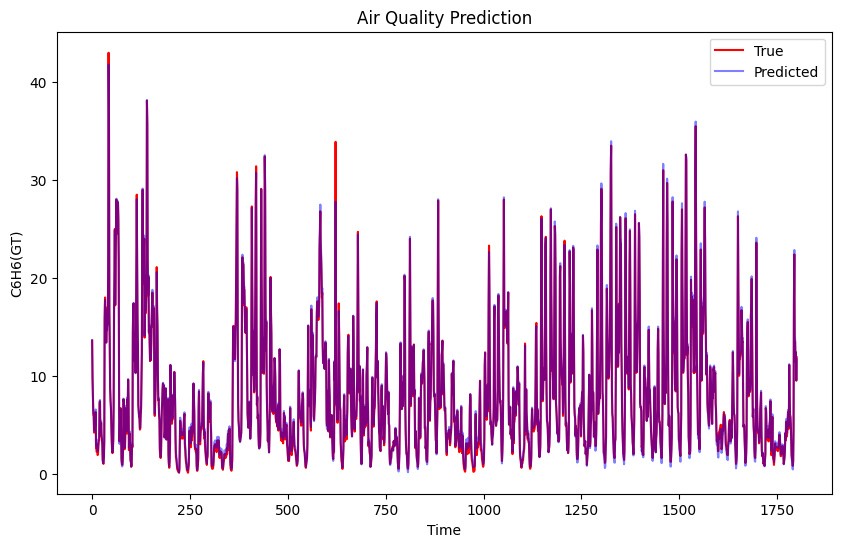

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, color='red', label='True')
plt.plot(y_pred, color='blue', label='Predicted', alpha=0.5)
plt.title('Air Quality Prediction')
plt.ylabel('C6H6(GT)')
plt.xlabel('Time')
plt.legend()
plt.show()

From the plot above we can deduce that the test set is predicted satisfactorily, even if in the Time interval [500:750] the real time series makes a peak which is only partially predicted: you can see a red piece not "covered" by the blue plot. Moreover, around Time 1000 the predictions seem to be too high. Let's see this region better. 

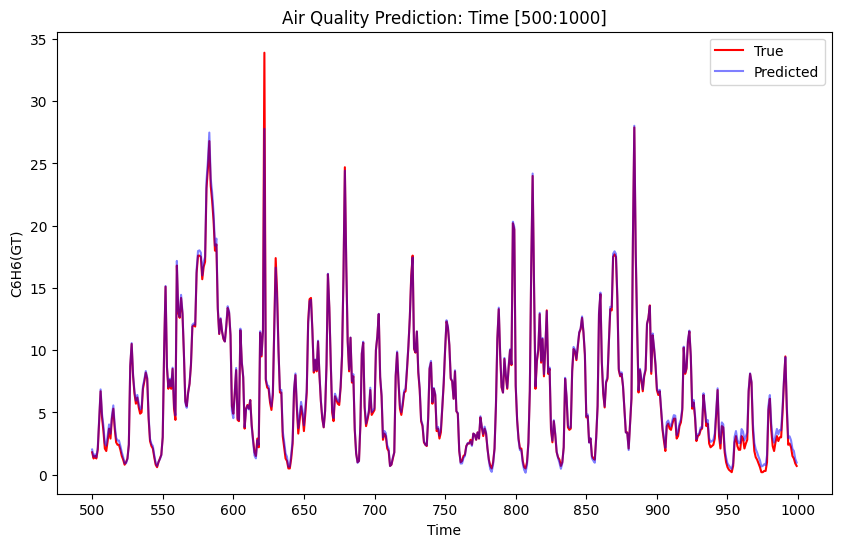

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(y_test[500:1000], color='red', label='True')
plt.plot(y_pred[500:1000], color='blue', label='Predicted', alpha=0.5)
plt.title('Air Quality Prediction: Time [500:1000]')
plt.ylabel('C6H6(GT)')
plt.xticks(range(0, 1000-500+1, 50), range(500, 1001, 50))
plt.xlabel('Time')
plt.legend()
plt.show()

### Stacked LSTM Model
Let's try with a stacked LSTM model: 3 LSTM layers of 50 units. In hidden layers I set `return_sequences=True` to preserve sequence information across LSTM layers and facilitate hierarchical learning of sequence features.

In [30]:
model = Sequential()
model.add(Input(shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))  
model.add(LSTM(50, activation='relu', return_sequences=True, name='lstm1')) 
model.add(LSTM(50, activation='relu', return_sequences=True, name='lstm2')) 
model.add(LSTM(50, activation='relu', return_sequences=False, name='lstm3'))
model.add(Dense(1, name='dense'))  

model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm1 (LSTM)                    │ (None, 1, 50)          │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm2 (LSTM)                    │ (None, 1, 50)          │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm3 (LSTM)                    │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,651 (201.76 KB)

 Trainable params: 51,651 (201.76 KB)

 Non-trainable params: 0 (0.00 B)

#### Training Phase

In [31]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=5, restore_best_weights=True)
history = model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=32, validation_data=(X_val_scaled, y_val_scaled), shuffle=False, callbacks=[early_stopping])

Epoch 1/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0310 - val_loss: 0.0027
Epoch 2/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - loss: 0.0019 - val_loss: 0.0017
Epoch 3/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - loss: 0.0015 - val_loss: 0.0016
Epoch 4/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - loss: 0.0013 - val_loss: 0.0015
Epoch 5/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - loss: 0.0011 - val_loss: 0.0014
Epoch 6/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - loss: 9.3542e-04 - val_loss: 0.0012
Epoch 7/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - loss: 7.7857e-04 - val_loss: 0.0011
Epoch 8/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - loss: 6.3594e-04 - val_loss: 0.0011
Epoch 9/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - loss: 5.0449e-04 - val_loss: 9.5611e-04
Epoch 10/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - loss: 3.4428e-04 - val_loss: 6.8698e-04
Epoch 11/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - loss: 2.1956e-04 - val_lo

Test Loss: 1.7320990082225762e-05



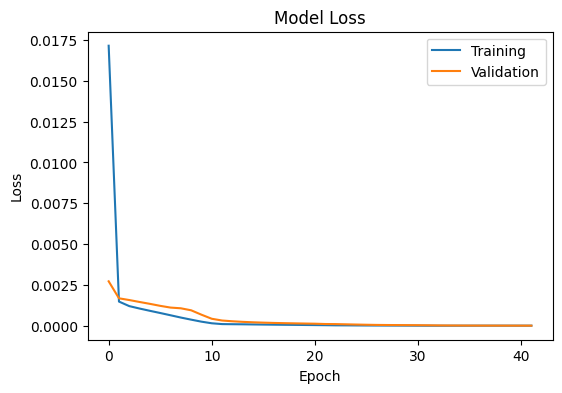

In [32]:
# Print test loss and accuracy
loss = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)
print(f'Test Loss: {loss}\n')

history = history.history

# Plot training & validation loss 
plt.figure(figsize=(6, 4))
plt.plot(history['loss'], label='Training')
plt.plot(history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

#### Predictions

In [33]:
y_pred_scaled = model.predict(X_test_scaled)
y_pred_scaled = y_pred_scaled.reshape(-1, 1)

y_pred = y_scaler.inverse_transform(y_pred_scaled)

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [34]:
mse = mean_squared_error(y_test, y_pred)
print(f'MSE between y_test and y_pred: {mse.round(4)}')

r2 = r2_score(y_test, y_pred)
print(f'R2 between y_test and y_pred: {r2.round(4)}')

MSE between y_test and y_pred: 0.0465
R2 between y_test and y_pred: 0.9989


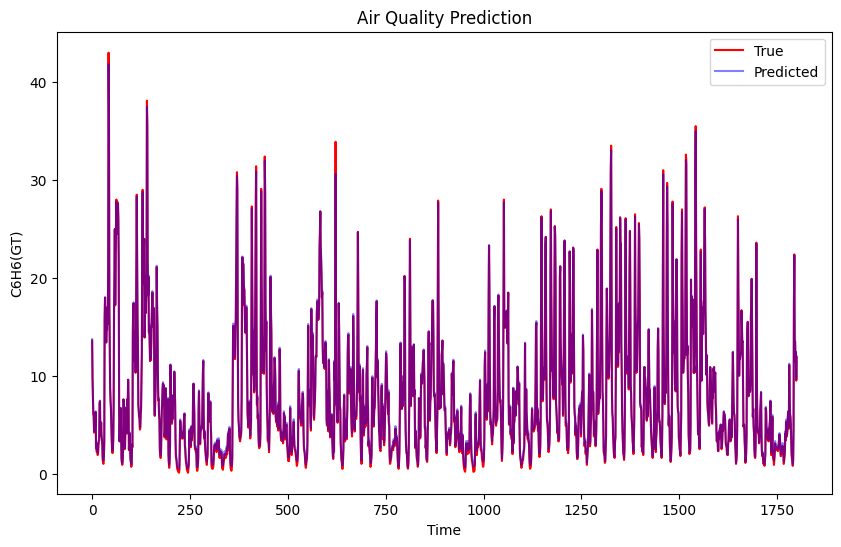

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, color='red', label='True')
plt.plot(y_pred, color='blue', label='Predicted', alpha=0.5)
plt.title('Air Quality Prediction')
plt.ylabel('C6H6(GT)')
plt.xlabel('Time')
plt.legend()
plt.show()

We can notice that, increasing the complexity of the model, the red pick in the Time interval [500:750] is now predicted quite well, better than the previous (vanilla) model; the same is true for the region around Time 1000 which is now more precise.

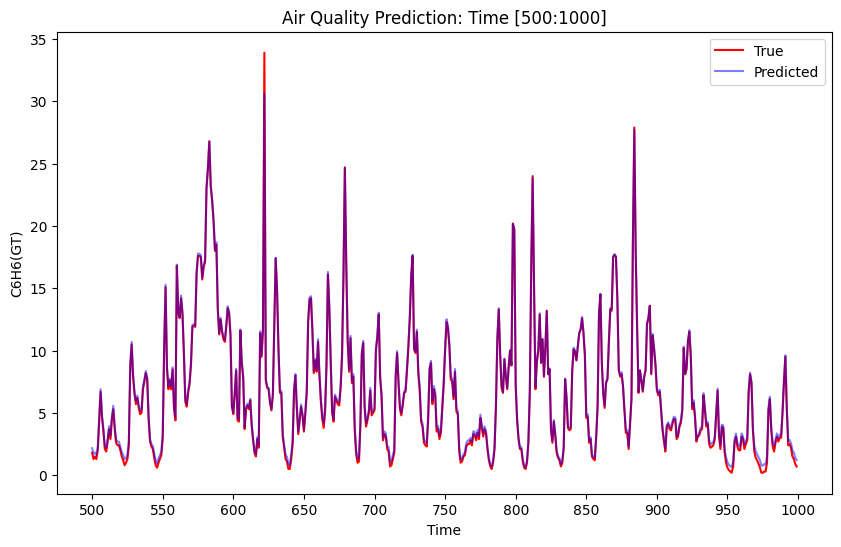

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(y_test[500:1000], color='red', label='True')
plt.plot(y_pred[500:1000], color='blue', label='Predicted', alpha=0.5)
plt.title('Air Quality Prediction: Time [500:1000]')
plt.ylabel('C6H6(GT)')
plt.xticks(range(0, 1000-500+1, 50), range(500, 1001, 50))
plt.xlabel('Time')
plt.legend()
plt.show()

## One-step ahead Model
Let's now move on to the second task and train a network on the Benzene column with a lag of 1: given the current benzene measurement, predict its next value.

In [37]:
# We have already split the data into train, val, and test sets paying attention to the order of the instances
train.shape, val.shape, test.shape

((5762, 7), (1428, 7), (1801, 7))

In [38]:
# Keep only the Benzene column
train_B = train[['C6H6(GT)']]
val_B = val[['C6H6(GT)']]
test_B = test[['C6H6(GT)']]

type(train_B), type(val_B), type(test_B)

(pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame)

In [39]:
# The target of each Benzene prediction will be the next Benzene value
def prepare_data(data):
    X = data[:-1]
    y = data[1:]
    return X, y

In [40]:
# Let the DataFrames become numpy arrays
train_B = train_B.to_numpy()
val_B = val_B.to_numpy()
test_B = test_B.to_numpy()

# Let's prepare the data
X_train_seq, y_train_seq = prepare_data(train_B)
X_val_seq, y_val_seq = prepare_data(val_B)
X_test_seq, y_test_seq = prepare_data(test_B)

In [41]:
X_train_seq.shape, y_train_seq.shape, X_val_seq.shape, y_val_seq.shape, X_test_seq.shape, y_test_seq.shape

((5761, 1), (5761, 1), (1427, 1), (1427, 1), (1800, 1), (1800, 1))

### Scaling

In [42]:
X_train_seq.min(), X_train_seq.max(), y_train_seq.min(), y_train_seq.max()

(0.3, 52.1, 0.3, 52.1)

In [43]:
# Scale X values
scaler = MinMaxScaler()
X_train_seq_scaled = scaler.fit_transform(X_train_seq)
X_val_seq_scaled = scaler.transform(X_val_seq)
X_test_seq_scaled = scaler.transform(X_test_seq)

# Scale y values with the same scaler used for X values
y_train_seq_scaled = scaler.transform(y_train_seq)
y_val_seq_scaled = scaler.transform(y_val_seq)
y_test_seq_scaled = scaler.transform(y_test_seq)

### Reshaping

In [44]:
X_train_seq_scaled = X_train_seq_scaled.reshape((X_train_seq_scaled.shape[0], 1, X_train_seq_scaled.shape[1]))
X_val_seq_scaled = X_val_seq_scaled.reshape((X_val_seq_scaled.shape[0], 1, X_val_seq_scaled.shape[1]))
X_test_seq_scaled = X_test_seq_scaled.reshape((X_test_seq_scaled.shape[0], 1, X_test_seq_scaled.shape[1]))

In [45]:
print(X_train_seq_scaled.shape, y_train_seq_scaled.shape)
print(X_val_seq_scaled.shape, y_val_seq_scaled.shape)
print(X_test_seq_scaled.shape, y_test_seq_scaled.shape)

(5761, 1, 1) (5761, 1)
(1427, 1, 1) (1427, 1)
(1800, 1, 1) (1800, 1)


### Vanilla LSTM Model
In order to make a direct comparison, we use the same model as in the sensor-based case: 1 LSTM layer with 10 units.

In [46]:
model = Sequential()
model.add(Input(shape=(X_train_seq_scaled.shape[1], X_train_seq_scaled.shape[2])))  
model.add(LSTM(10, activation='relu', return_sequences=False, name='lstm'))  
model.add(Dense(1, name='dense'))  

model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')  

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491 (1.92 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

#### Training Phase

In [47]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=5, restore_best_weights=True)
history = model.fit(X_train_seq_scaled, y_train_seq_scaled, epochs=100, batch_size=32, validation_data=(X_val_seq_scaled, y_val_seq_scaled), shuffle=False, callbacks=[early_stopping])

Epoch 1/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 870us/step - loss: 0.0301 - val_loss: 0.0154
Epoch 2/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 0.0119 - val_loss: 0.0126
Epoch 3/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 0.0100 - val_loss: 0.0099
Epoch 4/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 0.0083 - val_loss: 0.0080
Epoch 5/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 0.0073 - val_loss: 0.0071
Epoch 6/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 0.0069 - val_loss: 0.0067
Epoch 7/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 0.0068 - val_loss: 0.0066
Epoch 8/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 0.0068 - val_loss: 0.0065
Epoch 9/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 0.0068 - val_loss: 0.0065
Epoch 10/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 0.0067 - val_loss: 0.0064
Epoch 11/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 0.0067 - val_loss: 0.0064
Epoch 12/100
181/18

Test Loss: 0.005176459439098835



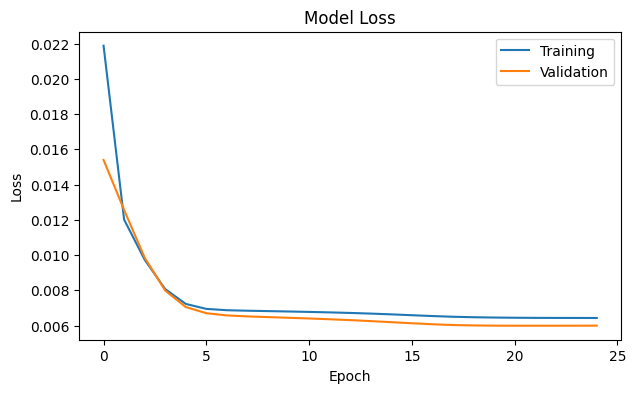

In [48]:
# Print test loss and accuracy
loss = model.evaluate(X_test_seq_scaled, y_test_seq_scaled, verbose=0)
print(f'Test Loss: {loss}\n')

history = history.history

# Plot training & validation loss 
plt.figure(figsize=(7, 4))
plt.plot(history['loss'], label='Training')
plt.plot(history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

#### Predictions

In [49]:
y_pred_seq_scaled = model.predict(X_test_seq_scaled)
y_pred_seq_scaled = y_pred_seq_scaled.reshape(-1, 1)

y_pred_seq = scaler.inverse_transform(y_pred_seq_scaled) 

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [50]:
y_test_seq.shape, y_pred_seq.shape

((1800, 1), (1800, 1))

In [51]:
mse = mean_squared_error(y_test_seq, y_pred_seq)
print(f'MSE between y_test_seq and y_pred_seq: {mse.round(4)}')

r2 = r2_score(y_test_seq, y_pred_seq)
print(f'R2 between y_test_seq and y_pred_seq: {r2.round(4)}')

MSE between y_test_seq and y_pred_seq: 13.8897
R2 between y_test_seq and y_pred_seq: 0.6726


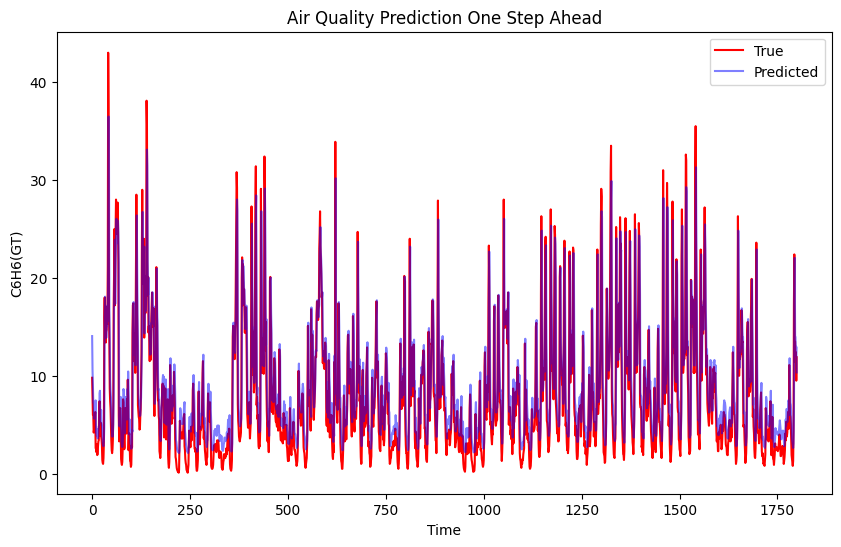

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_seq, color='red', label='True')
plt.plot(y_pred_seq, color='blue', label='Predicted', alpha=0.5)
plt.title('Air Quality Prediction One Step Ahead')
plt.ylabel('C6H6(GT)')
plt.xlabel('Time')
plt.legend()
plt.show()

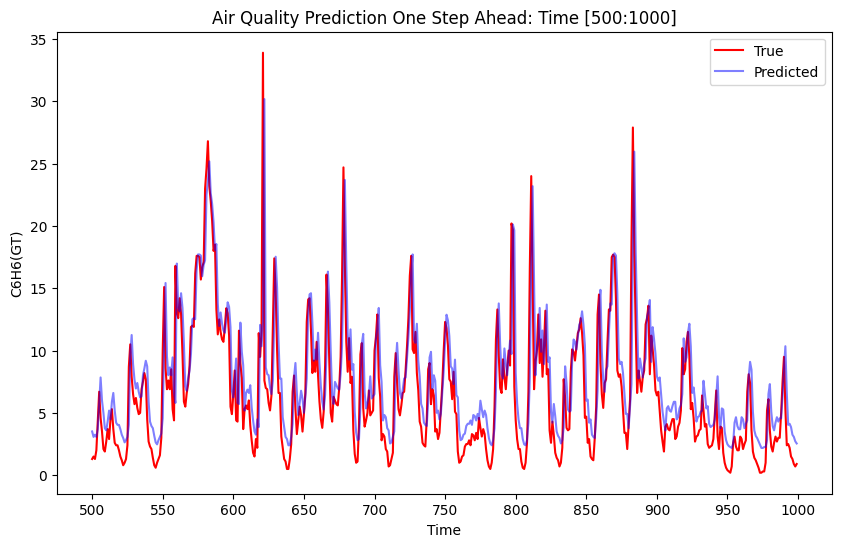

In [53]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_seq[500:1000], color='red', label='True')
plt.plot(y_pred_seq[500:1000], color='blue', label='Predicted', alpha=0.5)
plt.title('Air Quality Prediction One Step Ahead: Time [500:1000]')
plt.ylabel('C6H6(GT)')
plt.xticks(range(0, 1000-500+1, 50), range(500, 1001, 50))
plt.xlabel('Time')
plt.legend()
plt.show()

It is evident, both from the metrics and from the plots above, that with this simple model the prediction is much more approximate than in the case which took the PT08.* columns as input. Let's see if by increasing the complexity we can obtain better performances.

### Stacked LSTM Model

In [170]:
model = Sequential() 
model.add(Input(shape=(X_train_seq_scaled.shape[1], X_train_seq_scaled.shape[2])))  
model.add(LSTM(64, activation='relu', return_sequences=True, name='lstm1'))  
model.add(LSTM(64, activation='relu', return_sequences=True, name='lstm2'))
model.add(LSTM(64, activation='relu', return_sequences=True, name='lstm3'))
model.add(LSTM(64, activation='relu', return_sequences=True, name='lstm4'))
model.add(LSTM(32, activation='relu', return_sequences=True, name='lstm5'))
model.add(LSTM(32, activation='relu', return_sequences=True, name='lstm6'))
model.add(LSTM(16, activation='relu', return_sequences=True, name='lstm7'))
model.add(LSTM(16, activation='relu', return_sequences=False, name='lstm8'))
model.add(Dense(1, name='dense'))  

model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm1 (LSTM)                    │ (None, 1, 64)          │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm2 (LSTM)                    │ (None, 1, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm3 (LSTM)                    │ (None, 1, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm4 (LSTM)                    │ (None, 1, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm5 (LSTM)                    │ (None, 1, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm6 (LSTM)                    │ (None, 1, 32)          │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm7 (LSTM)                    │ (None, 1, 16)          │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm8 (LSTM)                    │ (None, 16)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 141,969 (554.57 KB)

 Trainable params: 141,969 (554.57 KB)

 Non-trainable params: 0 (0.00 B)

#### Training Phase

In [171]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=5, restore_best_weights=True)
history = model.fit(X_train_seq_scaled, y_train_seq_scaled, epochs=100, batch_size=32, validation_data=(X_val_seq_scaled, y_val_seq_scaled), shuffle=False, callbacks=[early_stopping])

Epoch 1/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0366 - val_loss: 0.0281
Epoch 2/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0193 - val_loss: 0.0268
Epoch 3/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0196 - val_loss: 0.0206
Epoch 4/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0152 - val_loss: 0.0099
Epoch 5/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072 - val_loss: 0.0070
Epoch 6/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0064 - val_loss: 0.0064
Epoch 7/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0064 - val_loss: 0.0062
Epoch 8/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0064 - val_loss: 0.0061
Epoch 9/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0064 - val_loss: 0.0060
Epoch 10/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0064 - val_loss: 0.0060
Epoch 11/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0064 - val_loss: 0.0060
Epoch 12/100
181/181 ━━━━━━━━━━━━━━━━━━━━

Test Loss: 0.004928362090140581



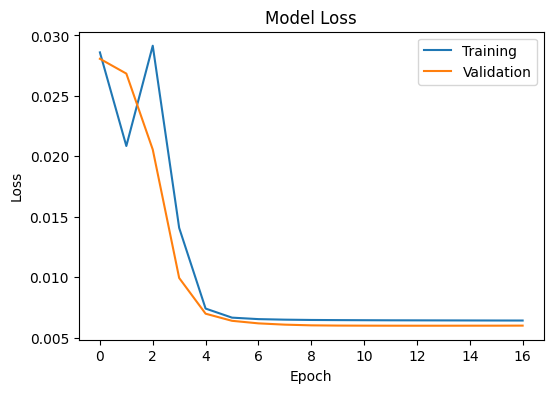

In [172]:
# Print test loss and accuracy
loss = model.evaluate(X_test_seq_scaled, y_test_seq_scaled, verbose=0)
print(f'Test Loss: {loss}\n')

history = history.history

# Plot training & validation loss
plt.figure(figsize=(6, 4))
plt.plot(history['loss'], label='Training')
plt.plot(history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

#### Predictions

In [173]:
y_pred_seq_scaled = model.predict(X_test_seq_scaled)
y_pred_seq_scaled = y_pred_seq_scaled.reshape(-1, 1)

y_pred_seq = scaler.inverse_transform(y_pred_seq_scaled)

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step 


In [174]:
mse = mean_squared_error(y_test_seq, y_pred_seq)
print(f'MSE between y_test_seq and y_pred_seq: {mse.round(4)}')

r2 = r2_score(y_test_seq, y_pred_seq)
print(f'R2 between y_test_seq and y_pred_seq: {r2.round(4)}')

MSE between y_test_seq and y_pred_seq: 13.224
R2 between y_test_seq and y_pred_seq: 0.6883


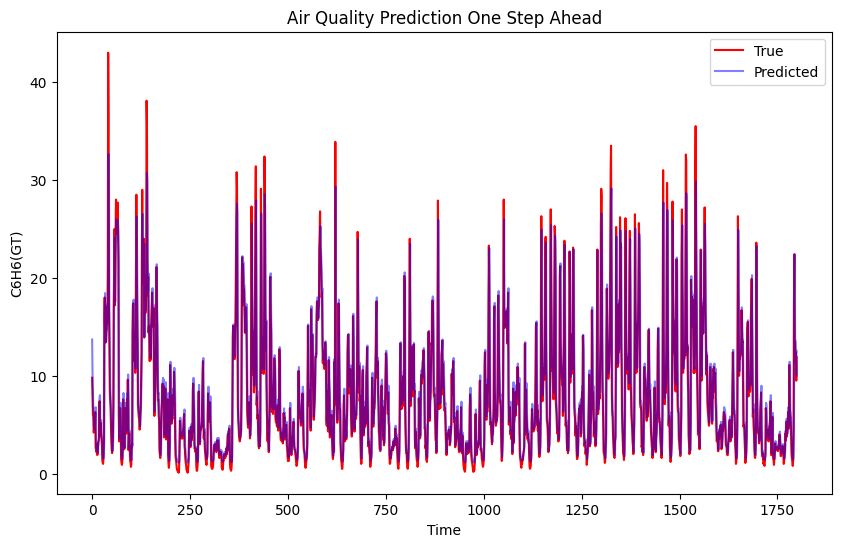

In [175]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_seq, color='red', label='True')
plt.plot(y_pred_seq, color='blue', label='Predicted', alpha=0.5)
plt.title('Air Quality Prediction One Step Ahead')
plt.ylabel('C6H6(GT)')
plt.xlabel('Time')
plt.legend()
plt.show()

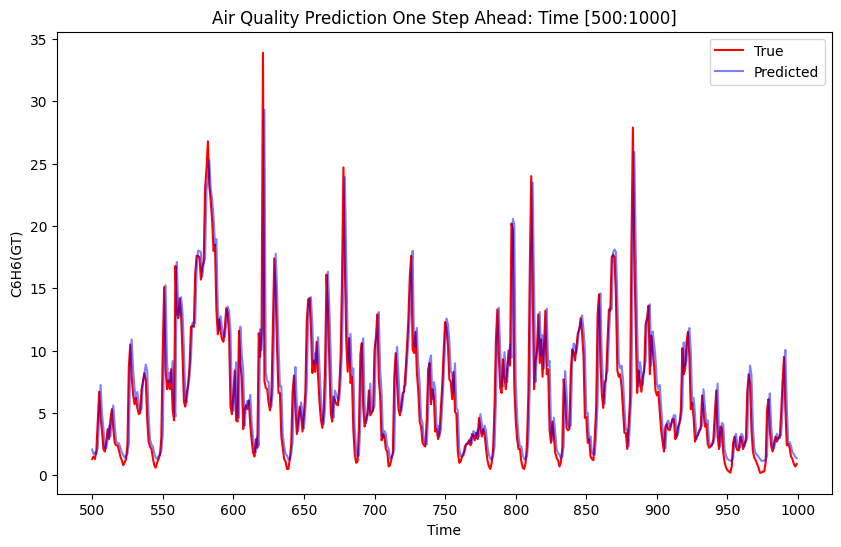

In [176]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_seq[500:1000], color='red', label='True')
plt.plot(y_pred_seq[500:1000], color='blue', label='Predicted', alpha=0.5)
plt.title('Air Quality Prediction One Step Ahead: Time [500:1000]')
plt.ylabel('C6H6(GT)')
plt.xticks(range(0, 1000-500+1, 50), range(500, 1001, 50))
plt.xlabel('Time')
plt.legend()
plt.show()

## Personal Considerations

The assigned task gave me the opportunity to work with Long Short-Term Memory units and to evaluate two different ways of assessing it: exploiting the measurements provided by some sensors, and simulating the eventuality of not having this data available and being able to rely only on the prediction of the previous step.

The sensor-based models gave excellent results in terms of metrics, and even by visually comparing the predictions and the true values ​​of the test set the high accuracy can be recognized. For the one-step ahead case, the model had to be complicated a bit in order to obtain better results. 

The metrics chosen for the evaluation are the Mean Squared Error ($MSE$) and the Coefficient of Determination ($R^2$), in formulas:
$$ MSE = \frac{1}{n}\sum_{i=1}^{n} (y_i - \hat{y_i})^2 $$
$$ R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y_i})^2}{\sum_{i=1}^{n} (y_i - \overline{y})^2} $$
where $n$ is the number of observations, $y_i$ is the actual value for the $i$-th observation, $\hat{y_i}$ is the predicted value, and $\overline{y}$ is the mean of the actual values.

For $MSE$ low values ​​are better, while for $R^2$ high values ​​are preferable (the maximum is 1). Let's briefly review the results for the various models: 

| Model                           | MSE       | R²       |
|---------------------------------|-----------|----------|
| Sensors Based Vanilla Model     | 0.081     | 0.9981   |
| Sensors Based Stacked Model     | 0.0465    | 0.9989   |
| One-step ahead Vanilla Model    | 13.8897   | 0.6726   |
| One-step ahead Stacked Model    | 13.224    | 0.6883   |

Note that for the Vanilla case the model is the same (1 layer of 10 units), while for the stacked case we have 3 layers of 50 units against 8 layers of 64-16 units. For sensors based models the $R^2$ score is very high and means that 99.8% of the variability in Benzene concentration is explained by the sensor measurements in the model. 

In this regard, we can see in the next cell that the Benzene column is highly correlated with the PT08.* columns, and this could justify the excellent performances of the first approach. On the other hand, the one-step ahead models rely on the assumption that the previous Benzene value is a good predictor of the next, which may not always capture underlying patterns as well.

In [177]:
# Correlations between the features of df and the target C6H6(GT)
df.corr()['C6H6(GT)']

DateTime        -0.064292
C6H6(GT)         1.000000
PT08.S1(CO)      0.883795
PT08.S2(NMHC)    0.981950
PT08.S3(NOx)    -0.735744
PT08.S4(NO2)     0.765731
PT08.S5(O3)      0.865689
Name: C6H6(GT), dtype: float64